# Final Project

In [1]:
import importlib 
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import base64
import utilsapi
importlib.reload(utilsapi)
import scipy.stats as stats
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import csv
from sklearn.preprocessing import MinMaxScaler

#### Cleaning Personal Spotify Data

In [2]:
spotify_data = pd.read_json("StreamingHistory1.json")
time_data = spotify_data['endTime']
dates_list = []
times_list = []
for item in time_data:
    values = item.split(' ')
    dates_list.append(values[0])
    times_list.append(values[1])
d = {'dates': dates_list, 'times': times_list}
split_df = pd.DataFrame(d)
extract_df = pd.DataFrame([spotify_data["artistName"], spotify_data["trackName"], spotify_data["msPlayed"]])
spotify_data = spotify_data.drop(columns=['endTime'])
final_df = pd.concat([split_df, spotify_data], axis=1, ignore_index=True)
mlseconds = final_df[4]
minutes = []
for i in mlseconds:
    minutes.append(round(i/60000, 2))
final_df['minutes'] = minutes
final_df = final_df.drop(columns=[4])

final_df.to_csv("final.csv")

##### Summing Daily Listening Time

In [3]:
time_data['date'] = final_df[0] 
time_data['minutes'] = final_df['minutes']
dates = []
total_minutes = []
prev_date = time_data['date'][0]
current_date = ""
total_time = 0

for i in range(len(time_data['date'])) :
    current_date = time_data['date'][i]
    if current_date == prev_date:
        total_time = round(total_time + time_data['minutes'][i], 2)
    if current_date != prev_date:
        dates.append(prev_date)
        total_minutes.append(total_time)
        total_time = 0
    prev_date = current_date
dates.append(current_date)
total_minutes.append(total_time)

daily_time = pd.DataFrame(dates, columns=['date'])
daily_time['total_time'] = total_minutes
daily_time.to_csv("dailytime.csv")
print(daily_time.describe())

       total_time
count   83.000000
mean   135.069157
std    133.970363
min      0.000000
25%     36.420000
50%     88.620000
75%    189.530000
max    607.160000


### Weather API Request and Cleaning

In [4]:
# obtain daily weather data for 01/01/2021 until 10/20/2021 (I used the 20th because any later date made it error out)
daily_url = "https://meteostat.p.rapidapi.com/stations/daily"
daily_url += "?station=" + "KSFF0"
daily_url += "&start=2021-07-01&end=2021-09-29&units=imperial"
daily_headers = {"x-rapidapi-key": utilsapi.weather}
response = requests.get(url=daily_url, headers=daily_headers)
json_obj = json.loads(response.text)
data_obj = json_obj['data']
#load data_obj into a data frame and set the headers. 
df = pd.DataFrame(data_obj, columns= ['date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun'])
#replace values that are missing with np.nan so I can later use .isnull().mean()
df = df.fillna(value=np.nan)
# takes the average of isnulls within the column and creates a new dataframe with columns that only contain less than 75% of NaNs
df = df[df.columns[(df.isnull().mean() < 0.75)]]
#cleans up the data frame by filling NaNs 
df = df.interpolate(method='linear')
df = df.ffill()
df = df.bfill()
# prints out the cleaned data to a csv
df.to_csv("Spokane_daily_weather_cleaned.csv")


##### Grabbing Artists from Personal Data

In [5]:
artists = []
prev_artist = final_df[2][0]
index = 0;

for i in final_df[2]:
    if i in artists:
        continue
    else:
        artists.append(i)

artist = artists.remove("MakFlakes ") #this artist had to be removed because it returned a response with no item[0] (as if item didn't exist)
#this won't effect my data too much because I don't even remember who this artist is 

### Spotify API Requests for Artist Genre

In [6]:
genres = []

client_ID = utilsapi.CID_spotify
client_secret = utilsapi.CS_spotify

endpoint = "https://accounts.spotify.com/api/token"
API_endpoint = "https://api.spotify.com/v1/search"

def grab_accesstoken():
    message = client_ID + ":" + client_secret
    message_bytes = message.encode("ascii")
    base64_bytes = base64.b64encode(message_bytes)
    encoded_client_details = base64_bytes.decode("ascii")
    headers = {"Authorization": "Basic " + encoded_client_details}              
    body = {"grant_type": "client_credentials"}
    response = requests.post(url=endpoint, headers=headers, data=body)
    json_object = json.loads(response.text)
    return json_object["access_token"]

def make_request(access_token, full_url):
    headers = {"Accept": "application/json",
                "Content-Type": "application/json",
                "Authorization": "Bearer " + access_token}
    response = requests.get(url= full_url, headers=headers)
    json_object = json.loads(response.text)
    return json_object

def search_request(access_token, search_term, search_type):
    search_term = requests.utils.quote(search_term)
    search_type = requests.utils.quote(search_type)
    url = API_endpoint + "?q=" + search_term
    url += "&type=" + search_type
    print(url)
    json_obj = make_request(access_token, url)
    return json_obj

def get_genres(json_obj):
    artists = json_obj["artists"]
    items = artists["items"]
    if not items[0]:
        exit
    else:
        first_artist_item = items[0] # TODO: are they sorted by match confidence/popularity?
        genre = first_artist_item["genres"]
        return genre

access_token = grab_accesstoken()

for i in artists:
    json_obj = search_request(access_token, i, "artist")
    genre = get_genres(json_obj)
    if not genre:
        genres.append("NA")
    else:
        genres.append(genre)

https://api.spotify.com/v1/search?q=Bring%20Me%20The%20Horizon&type=artist
https://api.spotify.com/v1/search?q=Verzache&type=artist
https://api.spotify.com/v1/search?q=Rich%20Brian&type=artist
https://api.spotify.com/v1/search?q=Post%20Malone&type=artist
https://api.spotify.com/v1/search?q=Joji&type=artist
https://api.spotify.com/v1/search?q=Krys%20Talk&type=artist
https://api.spotify.com/v1/search?q=DPR%20LIVE&type=artist
https://api.spotify.com/v1/search?q=Bagger%20boy&type=artist
https://api.spotify.com/v1/search?q=Billy%20Marchiafava&type=artist
https://api.spotify.com/v1/search?q=The%20Weeknd&type=artist
https://api.spotify.com/v1/search?q=SoulChef&type=artist
https://api.spotify.com/v1/search?q=Topaz%20Jones&type=artist
https://api.spotify.com/v1/search?q=Frank%20Ocean&type=artist
https://api.spotify.com/v1/search?q=Khalid&type=artist
https://api.spotify.com/v1/search?q=Aaron%20May&type=artist
https://api.spotify.com/v1/search?q=Childish%20Gambino&type=artist
https://api.spotify.

In [7]:
cleaned_genres = []
genre_totals = []
g_counts = []
for i in genres:
    if i == "NA":
        cleaned_genres.append("NA")
    else:
        cleaned_genres.append(i[0])

In [8]:
final_artists = pd.DataFrame(artists, columns=["artist"])
final_artists['genre'] = cleaned_genres 
print(final_artists)

temp_df = final_df[2]
temp_genres = []
for i in temp_df:
    if i in artists:
        index = artists.index(i)
        temp_genres.append(cleaned_genres[index])
    else: 
        temp_genres.append("NA")

final_df['genres'] = temp_genres

                   artist               genre
0    Bring Me The Horizon   melodic metalcore
1                Verzache           lo-fi rap
2              Rich Brian  indonesian hip hop
3             Post Malone             dfw rap
4                    Joji     alternative r&b
..                    ...                 ...
461                     Q        classic rock
462                Giveon                 pop
463                Masego                  NA
464                   UMI     alternative r&b
465                 dhruv           chill r&b

[466 rows x 2 columns]


### Hypothesis Testing

For my hypothesis I will be testing the relationship between daily average temperature and the total minutes I listen everyday. I believe that as the weather gets colder and school begins, I spend more time daily listening to music. Perhaps this is because I am more restricted to indoor activities. So I will be testing the following:

$H_0$ : In july, $\mu$ listening time < $\mu$ temperature and in September $\mu$ listening time > $\mu$ temperature

$H_1$ : In july, $\mu$ listening time > $\mu$ temperature and in September $\mu$ listening time < $\mu$ temperature

We will use a level of significane $\alpha = 0.05$  
Then we will use a 1 tailed, 2 independent sample t-test. Since we will be testing both July and September, we will be 2 seperate tests. So next lets get the data for the two months.

In [9]:
july_time = daily_time.loc[:29, 'total_time']
september_time = daily_time.loc[57:, 'total_time']
july_temp = df.loc[:32, 'tavg']
september_temp = df.loc[64:, 'tavg']

print("july:", len(july_time))
print("september:", len(september_time))

july: 30
september: 26


In [10]:
#july testing 

dof = len(july_time) - 1
print(dof)

29


Our degree of freedom return 29 and level of significance is 0.05. Based on the t-table, our t-critial is 1.69. Therefore in July, if we return with t-calculated greater than 1.69 we will reject null hypothesis.

In [11]:
t, p = stats.ttest_ind(july_time, july_temp)
print("t:", t)
if t > 1.69:
    print("Reject hypothesis")
else:
    print("Accept hypothesis")

t: 1.04983426963052
Accept hypothesis


In [12]:
dof = len(september_time) - 1
print(dof)

25


Next when we test for September our degree of freedom is 25 and the level of significance is 0.05. This makes our t-critical to be 1.708. So in our Sepember test, we should reject the null hypothesis if t-calculated is less than 1.708.

In [13]:
t, p = stats.ttest_ind(september_time, september_temp)
print("t:", t)
if t < 1.708:
    print("Reject hypothesis")
else:
    print("Accept hypothesis")

t: 3.7982055993570145
Accept hypothesis


The two tests performed above leads us to accept the null hypothesis. This concludes that I spend more time listening to music when the temperature starts to drop. There may be a number of reasons for this. However, I strongly belive that it's caused by decrease in outdoor activities and starting school. 

Text(0.5, 1.0, 'Daily Listening Time')

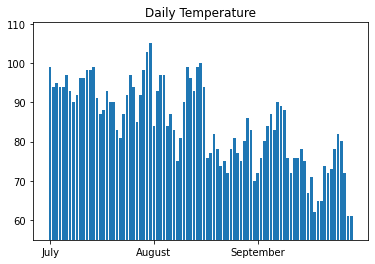

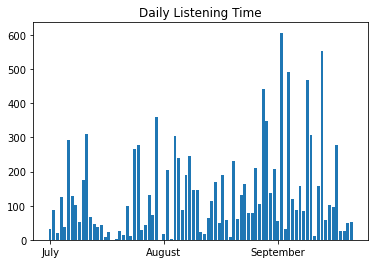

In [14]:
dates = df["date"]
temp = df["tmax"]
plt.bar(dates,temp)
plt.ylim(55)
plt.xlim(-5,95)
plt.xticks([0,31,62], ('July', 'August', 'September'))
plt.title("Daily Temperature")

x = daily_time['date']
y = daily_time['total_time']
plt.figure()
plt.bar(x, y)
plt.xticks([0,31,62], ('July', 'August', 'September'))
plt.title("Daily Listening Time")

The following graphs display both listening time and temperature. It provides a visual version of my hypothesis. We can see here that there is an inverse relationship between weather and time spent listenig to music. 

### ML on Artist Genre

In [15]:
le = preprocessing.LabelEncoder()
genres = le.fit_transform(final_df.loc[:, 'genres'])
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))

write = open("genre_keys.txt", "w")
write.write(str(dictionary))
write.close()

final_df['encoded_genre'] = genres

In [16]:
daily_genres = []
prev_date = final_df[0][0]
temp_genres =[]
c = 0
def most_common(lst):
    return max(set(lst), key=lst.count)

for i in final_df[0]:
    if i == prev_date:
        temp_genres.append(final_df['encoded_genre'][c])
    else:
        if len(temp_genres) == 0:
            daily_genres.append(0)
        else:
            daily_genres.append(most_common(temp_genres))
            temp_genres = [0]
    c+=1
    prev_date = i

print(len(daily_genres))
daily_genres.append(100)

df = df.drop([3, 16, 20, 34, 36,55, 56,75], axis=0)
print(len(df))

82
83


In [18]:
temp = df['tavg']
X = temp
X['time'] = daily_time['total_time']
Y = daily_genres
Y.append(100)
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.33, random_state=42)
# https://github.com/davidsbatista/text-classification/issues/1 

for index, item in enumerate(Y):
    if item == 0:
        Y[index] = 109

<ipython-input-18-96397e0cf198>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['time'] = daily_time['total_time']


In [26]:
scaler = MinMaxScaler()
scaler.fit(X)
x_train_normalized = scaler.transform(x_train)
x_test_normalized = scaler.transform(x_test)


ValueError: setting an array element with a sequence.

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=0)
tree_clf.fit(x_train, y_train)
y_predicted = tree_clf.predict(x_test)
accuracy = tree_clf.score(x_test, y_test)
print(accuracy)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').